# Data Analysis & Preprocessing
This notebook contains code that analyses the contents of the database. It plots the distribution of subclasses per superclass and analyzes any similarity between the various categories. There is additional code that explores transforming the images to improve the performances of our models. These transformations include rotation, shits, flips, and zooms.

In [1]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.models import googlenet

import torchvision

from torch.utils.data import Dataset, DataLoader, BatchSampler, random_split
from torchvision import transforms
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from scipy.special import k1
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from google.colab import drive

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Second Year [2023]/Fall Semester/NNDL/Project/data/Released_Data/'

contents = os.listdir(file_path)

# Print the contents
for item in contents:
    print(item)

Mounted at /content/drive
train_shuffle.zip
train_data.csv
test_shuffle.zip
superclass_mapping.csv
subclass_mapping.csv
example_test_predictions.csv
README.txt
test_shuffle
train_shuffle
simple_cnn_demo.ipynb
train_shuffle_sharpened
train_shuffle_transformed


In [3]:
train_data_mapping_df = pd.read_csv(file_path + 'train_data.csv')

super_classes_mapping_df = pd.read_csv(file_path + 'superclass_mapping.csv')
super_classes_mapping_df = super_classes_mapping_df.rename(columns={"index": "superclass_index", "class": "sub_class"})

sub_classes_mapping_df = pd.read_csv(file_path + 'subclass_mapping.csv')
sub_classes_mapping_df = sub_classes_mapping_df.rename(columns={"index": "subclass_index", "class": "sub_class"})

print("Num sub-class mappings: ", len(sub_classes_mapping_df))
print("Num super-class mappings: ", len(super_classes_mapping_df))
print("Num training data mappings: ", len(train_data_mapping_df))

Num sub-class mappings:  88
Num super-class mappings:  4
Num training data mappings:  6322


In [4]:
# train_data_mapping_df.head()

In [5]:
# super_classes_mapping_df.head()

In [6]:
# sub_classes_mapping_df.head()

In [7]:
train_dir = file_path + "train_shuffle"
test_dir = file_path + "test_shuffle"

def preprocess_image(image_path):
    image = Image.open(image_path)

    if image.size != (32, 32):
        raise ValueError("Image is not 32x32 pixels in size.")

    image_array = np.array(image).astype('float32') / 255.0

    return image_array

def create_dataframe_from_images(directory):
    filenames = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    images = [preprocess_image(os.path.join(directory, f)) for f in filenames]
    df = pd.DataFrame({'image': filenames, 'image_data': images})

    return df

train_df = create_dataframe_from_images(train_dir)
test_df = create_dataframe_from_images(test_dir)

In [8]:
# train_df.head()

In [9]:
# test_df.head()

In [14]:
full_train_df = pd.merge(train_df, train_data_mapping_df, on='image', how='inner')
full_train_df = pd.merge(full_train_df, super_classes_mapping_df, on='superclass_index', how='inner')
full_train_df = pd.merge(full_train_df, sub_classes_mapping_df, on='subclass_index', how='inner')
full_train_df = full_train_df.drop(["superclass_index", "subclass_index"], axis=1)
full_train_df = full_train_df.rename(columns={"sub_class_x": "superclass", "sub_class_y": "subclass"})
full_train_df.head()

image                                         image_data superclass  \
0  5472.jpg  [[[0.41960785, 0.43137255, 0.3882353], [0.4941...    reptile   
1  3188.jpg  [[[0.5647059, 0.54509807, 0.57254905], [0.5686...    reptile   
2  3749.jpg  [[[0.5058824, 0.3019608, 0.24705882], [0.52941...    reptile   
3   780.jpg  [[[0.60784316, 0.52156866, 0.47058824], [0.615...    reptile   
4  4422.jpg  [[[0.5294118, 0.5176471, 0.48235294], [0.52156...    reptile   

                                        subclass  
0  ringneck snake, ring-necked snake, ring snake  
1  ringneck snake, ring-necked snake, ring snake  
2  ringneck snake, ring-necked snake, ring snake  
3  ringneck snake, ring-necked snake, ring snake  
4  ringneck snake, ring-necked snake, ring snake

In [16]:
full_test_df = pd.merge(test_df, train_data_mapping_df, on='image', how='inner')
# full_train_df = pd.merge(full_train_df, super_classes_mapping_df, on='superclass_index', how='inner')
# full_train_df = pd.merge(full_train_df, sub_classes_mapping_df, on='subclass_index', how='inner')
# full_train_df = full_train_df.drop(["superclass_index", "subclass_index"], axis=1)
# full_train_df = full_train_df.rename(columns={"sub_class_x": "superclass", "sub_class_y": "subclass"})
full_test_df.head()

image                                         image_data  \
0   554.jpg  [[[0.5058824, 0.5803922, 0.32941177], [0.48235...   
1  1215.jpg  [[[0.14117648, 0.16470589, 0.16470589], [0.109...   
2  5488.jpg  [[[0.31764707, 0.4862745, 0.50980395], [0.2941...   
3  4351.jpg  [[[0.047058824, 0.2, 0.0], [0.17254902, 0.3019...   
4  4609.jpg  [[[0.20784314, 0.08627451, 0.14509805], [0.258...   

   superclass_index  subclass_index  
0                 1              22  
1                 2              63  
2                 2              69  
3                 0              75  
4                 1               9

In [17]:
full_train_df.iloc[0]['image_data'].shape

(32, 32, 3)

## Superclass & Subclass Distributions

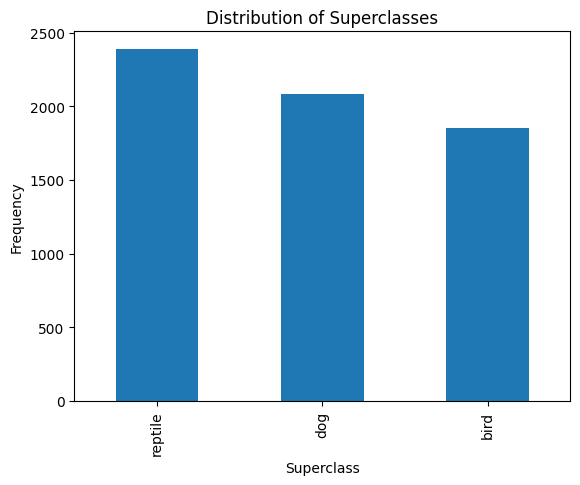

In [18]:
superclass_counts = full_train_df['superclass'].value_counts()
superclass_counts.plot(kind='bar')
plt.title('Distribution of Superclasses')
plt.xlabel('Superclass')
plt.ylabel('Frequency')
plt.show()

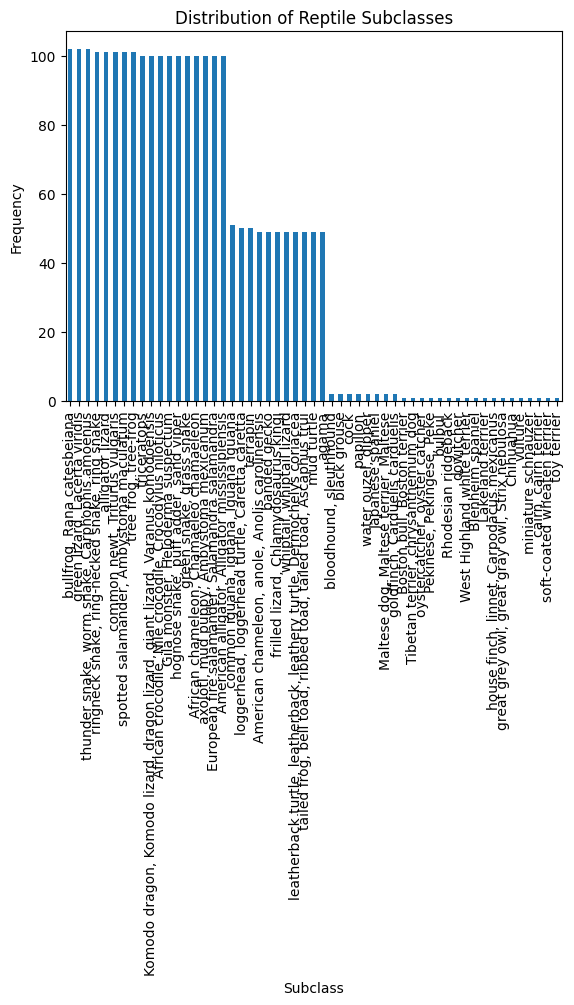

In [ ]:
reptile_train_df = full_train_df[full_train_df['superclass']=='reptile']
subclass_counts = reptile_train_df['subclass'].value_counts()
subclass_counts.plot(kind='bar')
plt.title('Distribution of Reptile Subclasses')
plt.xlabel('Subclass')
plt.ylabel('Occurence')
plt.show()

In [ ]:
print("Number of unique reprile sub-classes: ", subclass_counts)

Number of unique reprile sub-classes:  water ouzel, dipper                                               100
black grouse                                                      100
bald eagle, American eagle, Haliaeetus leucocephalus              100
vulture                                                           100
magpie                                                            100
ptarmigan                                                         100
chickadee                                                         100
great grey owl, great gray owl, Strix nebulosa                    100
junco, snowbird                                                    50
redshank, Tringa totanus                                           50
American coot, marsh hen, mud hen, water hen, Fulica americana     50
hen                                                                50
ostrich, Struthio camelus                                          50
brambling, Fringilla montifringilla                

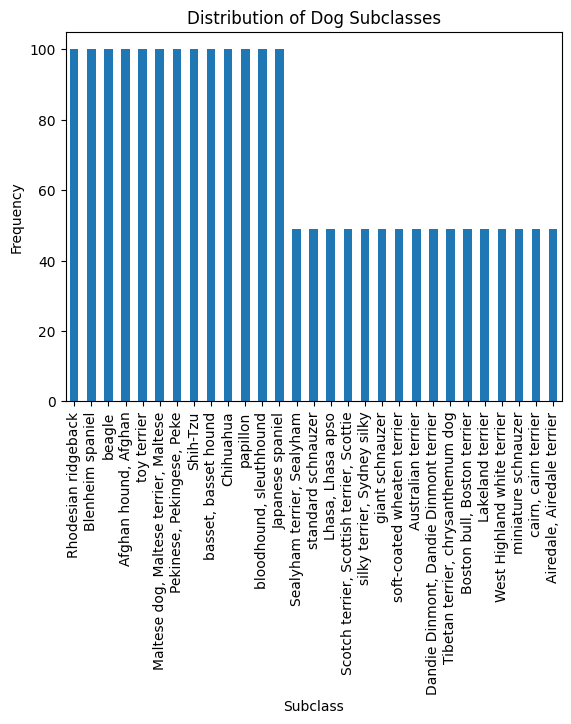

In [ ]:
dog_train_df = full_train_df[full_train_df['superclass']=='dog']
subclass_counts = dog_train_df['subclass'].value_counts()
subclass_counts.plot(kind='bar')
plt.title('Distribution of Dog Subclasses')
plt.xlabel('Subclass')
plt.ylabel('Frequency')
plt.show()

In [ ]:
print("Number of unique reprile sub-classes: ", len(dog_train_df['subclass'].unique()))

Number of unique reprile sub-classes:  29


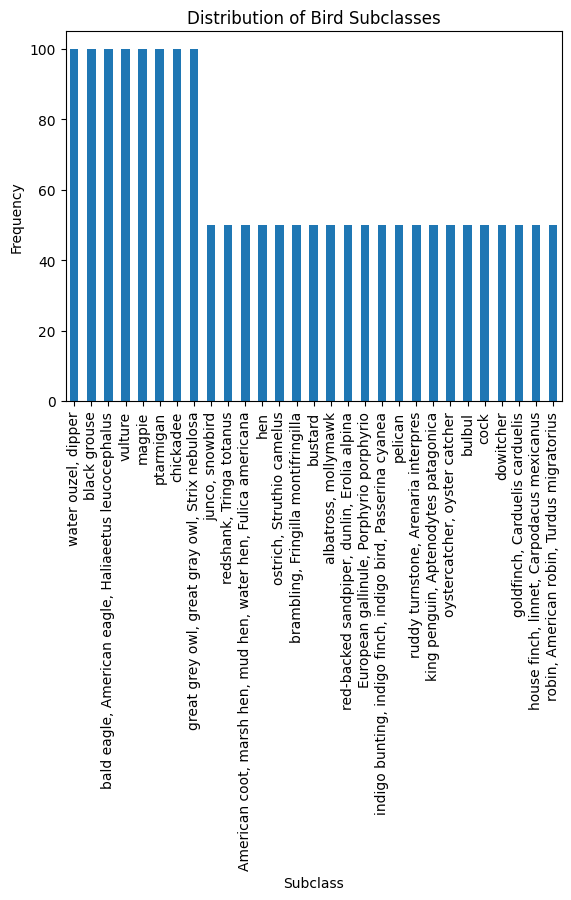

In [ ]:
bird_train_df = full_train_df[full_train_df['superclass']=='bird']
subclass_counts = bird_train_df['subclass'].value_counts()
subclass_counts.plot(kind='bar')
plt.title('Distribution of Bird Subclasses')
plt.xlabel('Subclass')
plt.ylabel('Frequency')
plt.show()

In [ ]:
print("Number of unique reprile sub-classes: ", len(bird_train_df['subclass'].unique()))

Number of unique reprile sub-classes:  29


## tSNE and PCA Models on Superclass distirbution

In [ ]:
# CITATION: Refactored from https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html and ChatGPT

# tSNE - superclass

X = np.array(full_train_df['image_data'].tolist())
n_samples, img_height, img_width, n_colors = X.shape
X_reshaped = X.reshape(n_samples, img_height * img_width * n_colors)

# X_reduced = pca.fit_transform(X_reshaped)

tsne = TSNE(n_components=2, random_state=0)
x_reduced = tsne.fit_transform(X_reshaped)


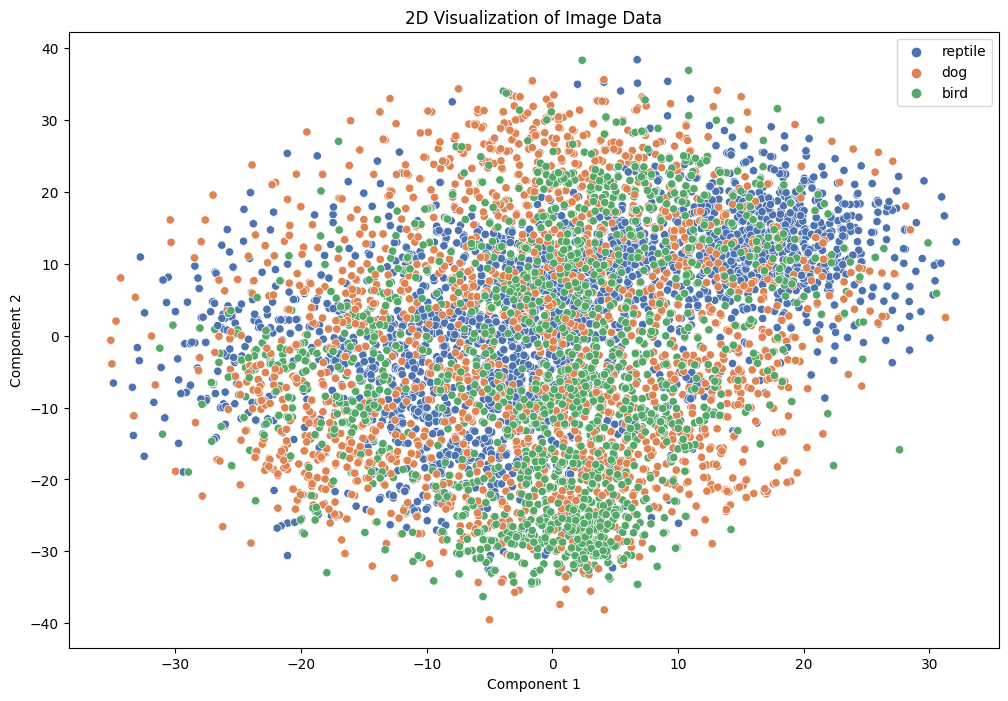

In [ ]:
category_labels = full_train_df['superclass']
plt.figure(figsize=(12, 8))
sns.scatterplot(x=x_reduced[:, 0], y=x_reduced[:, 1], hue=category_labels, palette='deep')
plt.title('2D Visualization of Image Data')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()


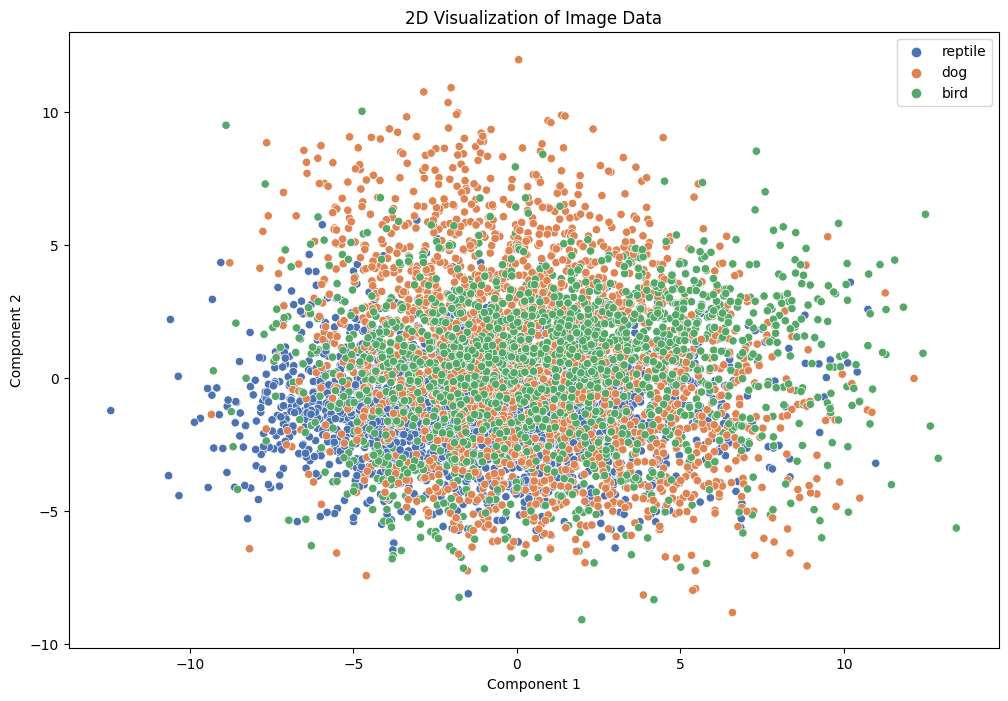

In [ ]:
# CITATION: Refactored from https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html and ChatGPT

# PCA - superclass
pca = PCA(n_components=2)
X_reduced_pca = pca.fit_transform(X_reshaped)

category_labels = full_train_df['superclass']
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_reduced_pca[:, 0], y=X_reduced_pca[:, 1], hue=category_labels, palette='deep')
plt.title('2D Visualization of Image Data')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()

In [ ]:
# specific_superclass = 'novel'
# novel_df = full_train_df[full_train_df['superclass'] == specific_superclass]
# len(novel_df['subclass'].unique())

## tSNE on Reptile Subclasses

<ipython-input-28-3e45bd7519f2>:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


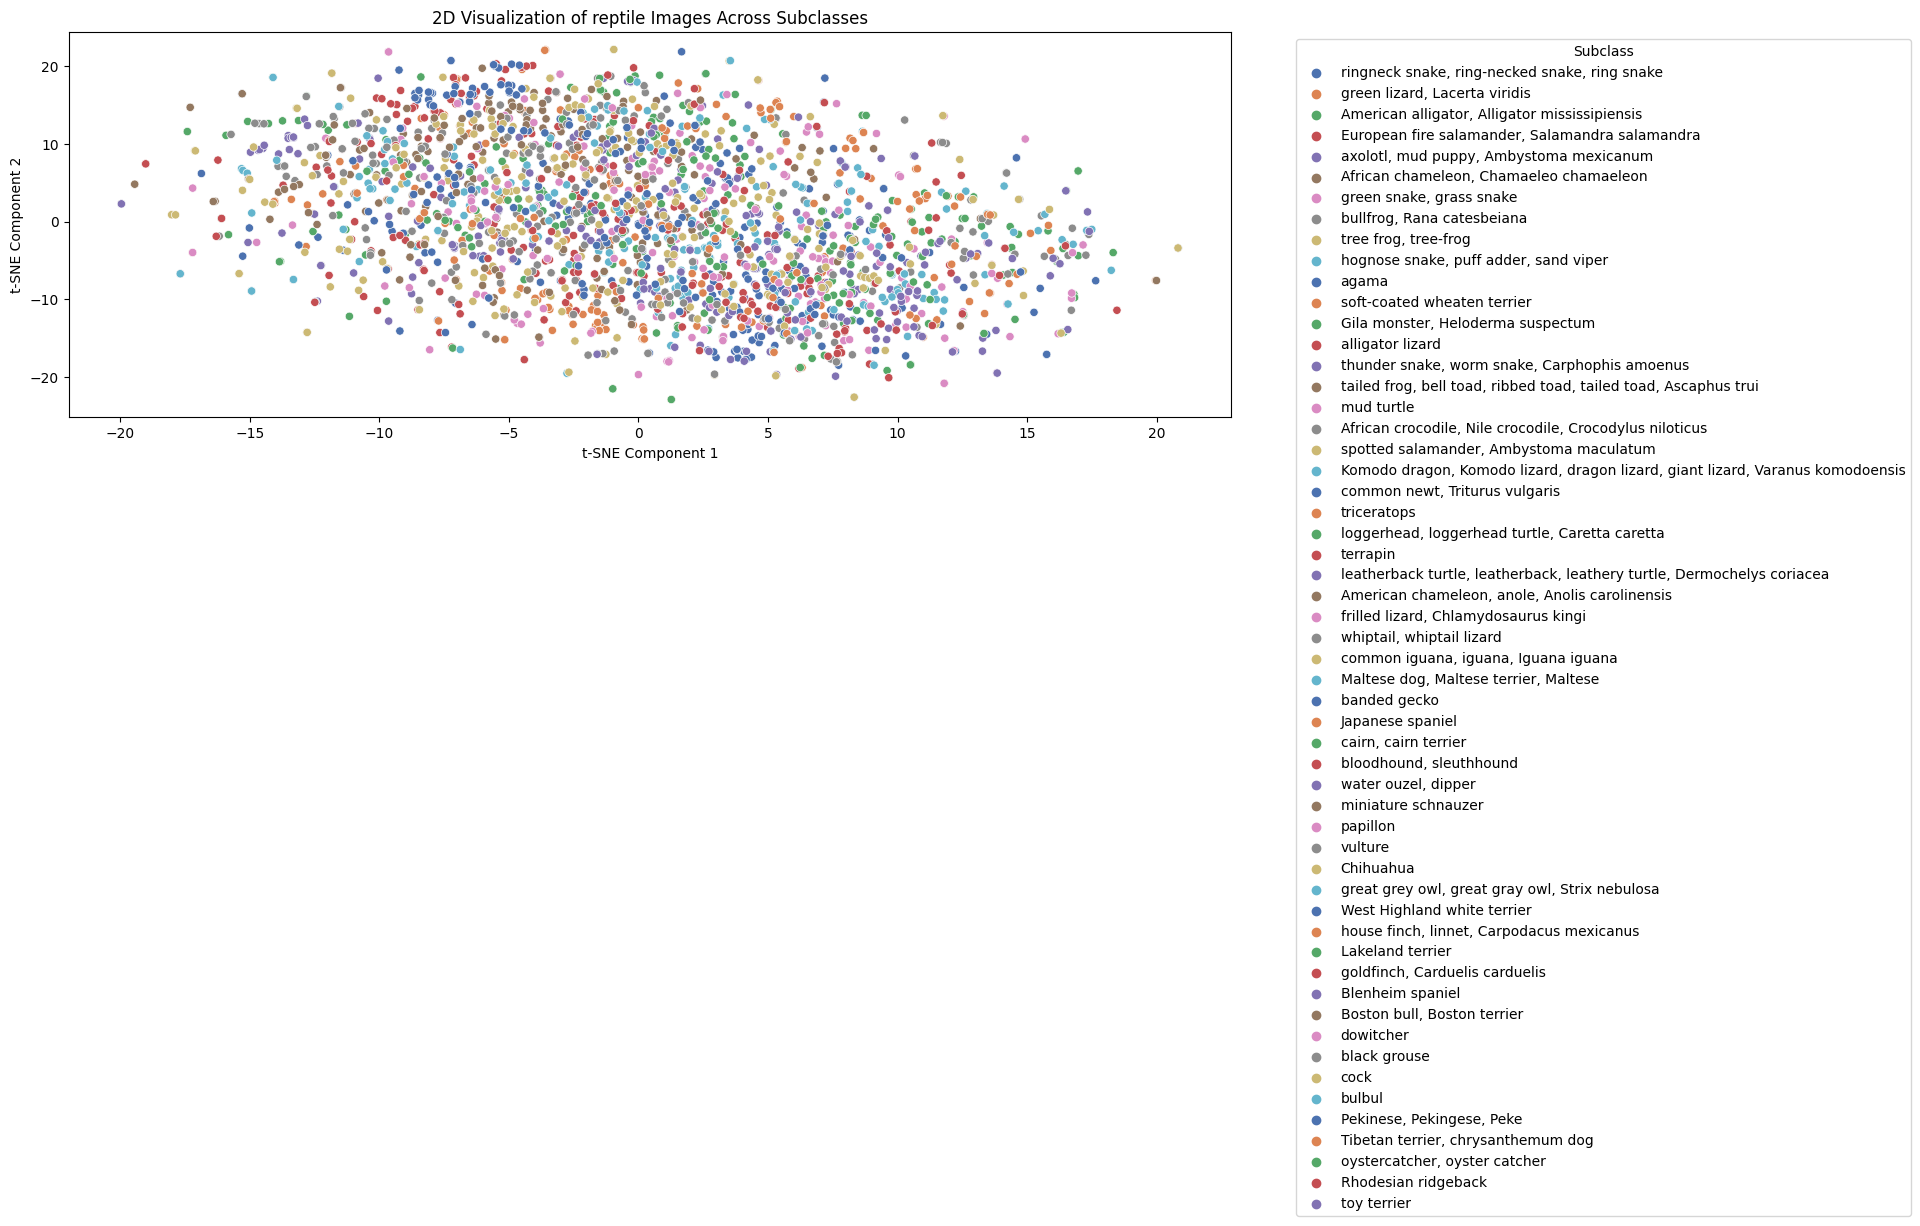

In [ ]:
# CITATION: Refactored from https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html and ChatGPT

# tSNE - Reptile Subclasses

specific_superclass = 'reptile'
reptile_df = full_train_df[full_train_df['superclass'] == specific_superclass]
X_reptile = np.array(reptile_df['image_data'].tolist())
n_samples, img_height, img_width, n_colors = X_reptile.shape
X_reptile_reshaped = X_reptile.reshape(n_samples, img_height * img_width * n_colors)

tsne = TSNE(n_components=2, random_state=0)
X_reptile_reduced = tsne.fit_transform(X_reptile_reshaped)

subclass_labels = reptile_df['subclass']
plt.figure(figsize=(15, 5))
sns.scatterplot(x=X_reptile_reduced[:, 0], y=X_reptile_reduced[:, 1], hue=subclass_labels, palette='deep')
plt.title(f'2D Visualization of {specific_superclass} Images Across Subclasses')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Subclass', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
len(reptile_df['subclass'].unique())


55

## tSNE on Dog Subclasses


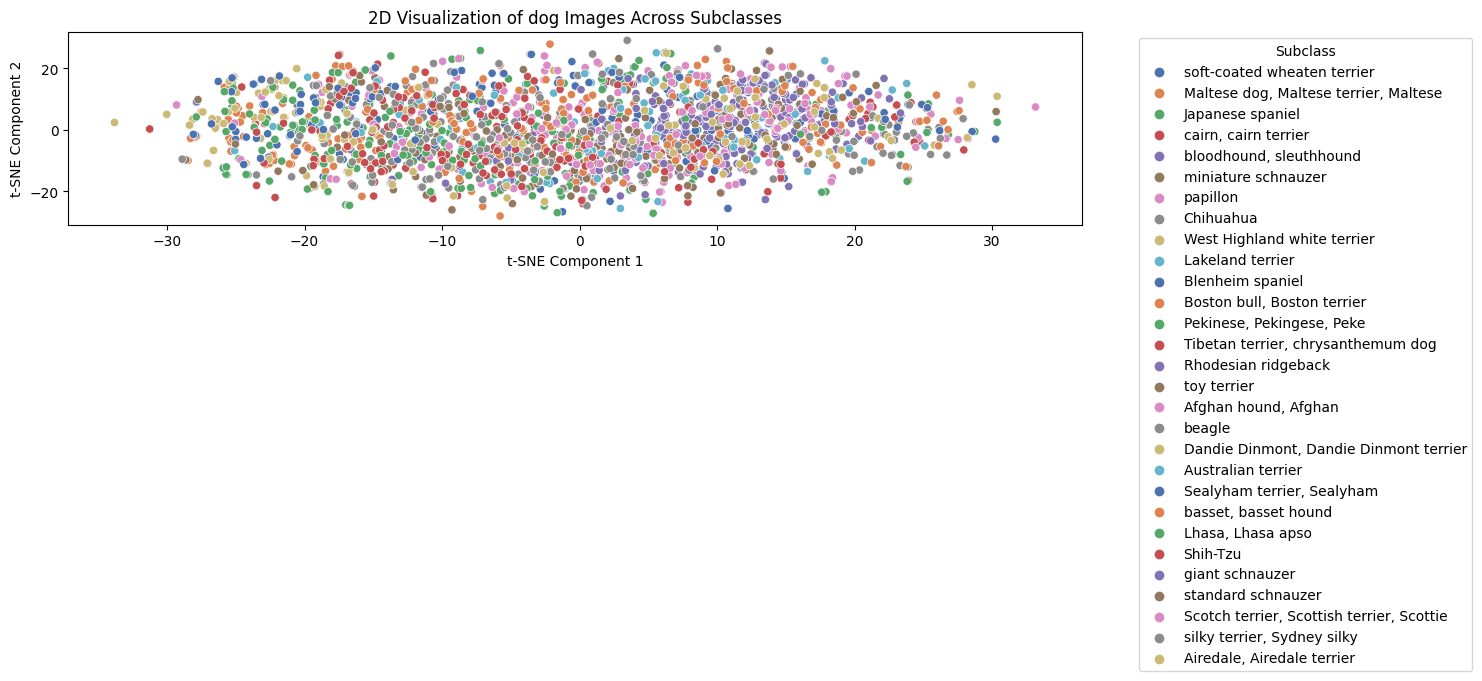

In [ ]:
# CITATION: Refactored from https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html and ChatGPT


# tSNE - Dog Subclasses

specific_superclass = 'dog'
dog_df = full_train_df[full_train_df['superclass'] == specific_superclass]
X_dog = np.array(dog_df['image_data'].tolist())
n_samples, img_height, img_width, n_colors = X_dog.shape
X_dog_reshaped = X_dog.reshape(n_samples, img_height * img_width * n_colors)

tsne = TSNE(n_components=2, random_state=0)
X_dog_reduced = tsne.fit_transform(X_dog_reshaped)

subclass_labels = dog_df['subclass']
plt.figure(figsize=(15, 5))
sns.scatterplot(x=X_dog_reduced[:, 0], y=X_dog_reduced[:, 1], hue=subclass_labels, palette='deep')
plt.title(f'2D Visualization of {specific_superclass} Images Across Subclasses')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Subclass', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
len(dog_df['subclass'].unique())


29

## tSNE on Bird Subclasses


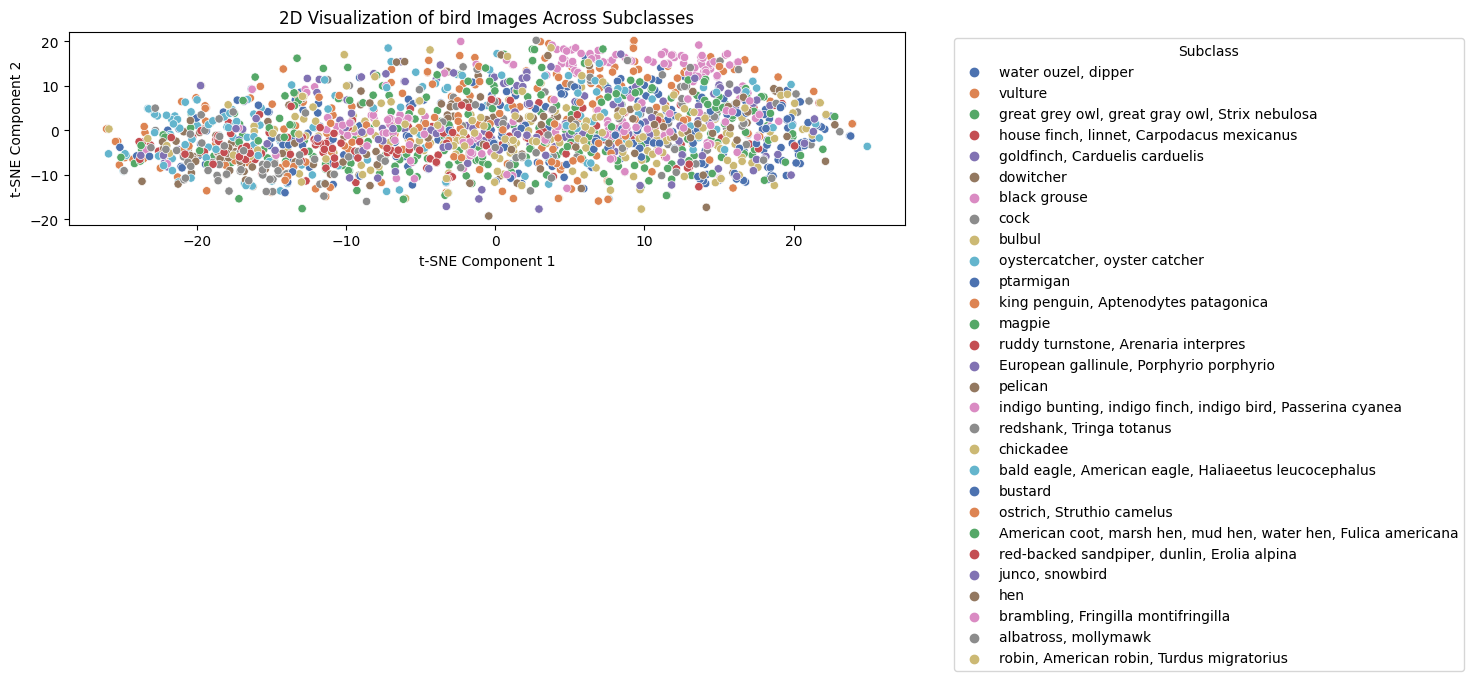

In [ ]:
# CITATION: Refactored from https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html and ChatGPT


# tSNE - Bird Subclasses

specific_superclass = 'bird'
bird_df = full_train_df[full_train_df['superclass'] == specific_superclass]
X_bird = np.array(bird_df['image_data'].tolist())
n_samples, img_height, img_width, n_colors = X_bird.shape
X_bird_reshaped = X_bird.reshape(n_samples, img_height * img_width * n_colors)

tsne = TSNE(n_components=2, random_state=0)
X_bird_reduced = tsne.fit_transform(X_bird_reshaped)

subclass_labels = bird_df['subclass']
plt.figure(figsize=(15, 5))
sns.scatterplot(x=X_bird_reduced[:, 0], y=X_bird_reduced[:, 1], hue=subclass_labels, palette='deep')
plt.title(f'2D Visualization of {specific_superclass} Images Across Subclasses')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Subclass', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
len(bird_df['subclass'].unique())

29

# Try sharpening images


(32, 32, 3)


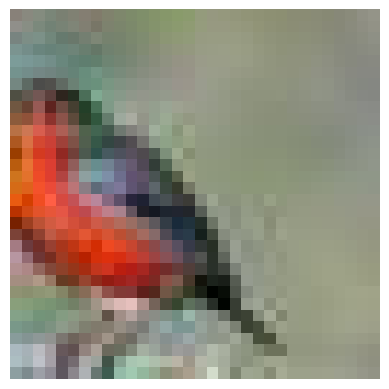

In [ ]:
# test_image_data = full_train_df.iloc[5000]['image_data'] # dog
test_image_data = full_train_df.iloc[6321]['image_data'] # dog
#
print(test_image_data.shape)

def show_image(img):
  plt.imshow(img)
  plt.axis('off')  # To turn off the axis
  plt.show()

show_image(test_image_data)

In [ ]:
def convolve_image(image, filter_matrix):
    ''' Convolve a 2D image using the filter matrix.
    Args:
        image: a 2D numpy array.
        filter_matrix: a 2D numpy array.
    Returns:
        the convolved image, which is a 2D numpy array same size as the input image.

    TODO: Implement the convolve_image function here.
    '''

    filter_shape = filter_matrix.shape
    im_out = np.zeros_like(image)  # initialize the output image array

    for channel in range(image.shape[2]):
        im_pad = np.pad(image[:, :, channel], [(filter_shape[0]//2, filter_shape[0]//2),
                                               (filter_shape[1]//2, filter_shape[1]//2)],
                        mode='constant')

        y_dim, x_dim = image.shape[:2]

        for j in range(y_dim):
            for i in range(x_dim):
                im_segment = np.array(im_pad[j:j+filter_shape[0], i:i+filter_shape[1]]) # change to filter size (nxn)
                im_segment = np.multiply(im_segment, filter_matrix)
                im_out[j, i, channel] = np.sum(im_segment)

    return im_out


def gaussian_filter(sigma, k=20):
    '''
    Args:
        sigma: the standard deviation of Gaussian kernel.
        k: controls size of the filter matrix.
    Returns:
        a 2D Gaussian filter matrix of the size (2k+1, 2k+1).

    TODO: Implement a Gaussian filter here.
    '''
    filter_matrix = np.zeros((2*k+1,2*k+1))
    for i in range(-k,k):
      for j in range(-k,k):
        expo_i = np.exp((-1/2)*((i**2)/(sigma**2)))
        expo_j = np.exp((-1/2)*((j**2)/(sigma**2)))
        filter_matrix[i+k][j+k] = (1/((sigma**2)*(2*np.pi)))*expo_i*expo_j


    return filter_matrix

def sharpening_filter(k=5):
    ''' Returns a 3x3 sharpening filter '''
    return np.array([[ 0, -1,  0],
                     [-1,  k, -1],
                     [ 0, -1,  0]])


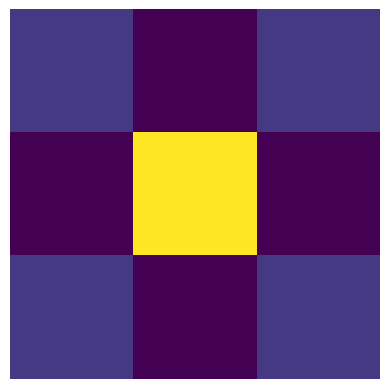

In [ ]:
show_image(sharpening_filter())

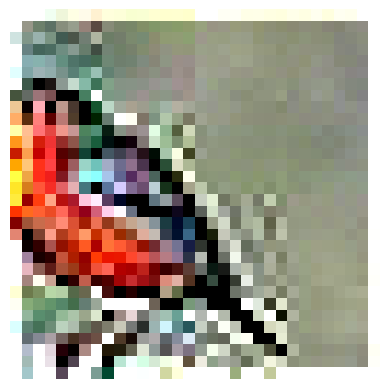

In [ ]:
new_img = show_image(convolve_image(test_image_data, sharpening_filter(5)))


In [ ]:
# Code Refactored from ChatGPT to save sharpened training images (not used)

sharpened_img_dir = file_path + 'train_shuffle_sharpened'
if not os.path.exists(sharpened_img_dir):
    os.makedirs(sharpened_img_dir)

for index, row in full_train_df.iterrows():
    image_data = row['image_data']
    sharpened_image = convolve_image(image_data, sharpening_filter(5))

    img = Image.fromarray((sharpened_image * 255).astype(np.uint8))
    img.save(os.path.join(sharpened_img_dir, row['image']))

# Code Refactored from ChatGPT to save sharpened images
print("All images have been sharpened and saved.")

All images have been sharpened and saved.


In [ ]:
# Code Refactored from ChatGPT to save sharpened test images (not used)

sharpened_img_dir = file_path + 'test_shuffle_sharpened'
if not os.path.exists(sharpened_img_dir):
    os.makedirs(sharpened_img_dir)

for index, row in test_df.iterrows():
    image_data = row['image_data']  # Assuming this is a numpy array; if not, convert it
    sharpened_image = convolve_image(image_data, sharpening_filter(5))

    img = Image.fromarray((sharpened_image * 255).astype(np.uint8))
    img.save(os.path.join(sharpened_img_dir, row['image']))
print("All images have been sharpened and saved.")

All images have been sharpened and saved.


## Random Rotation

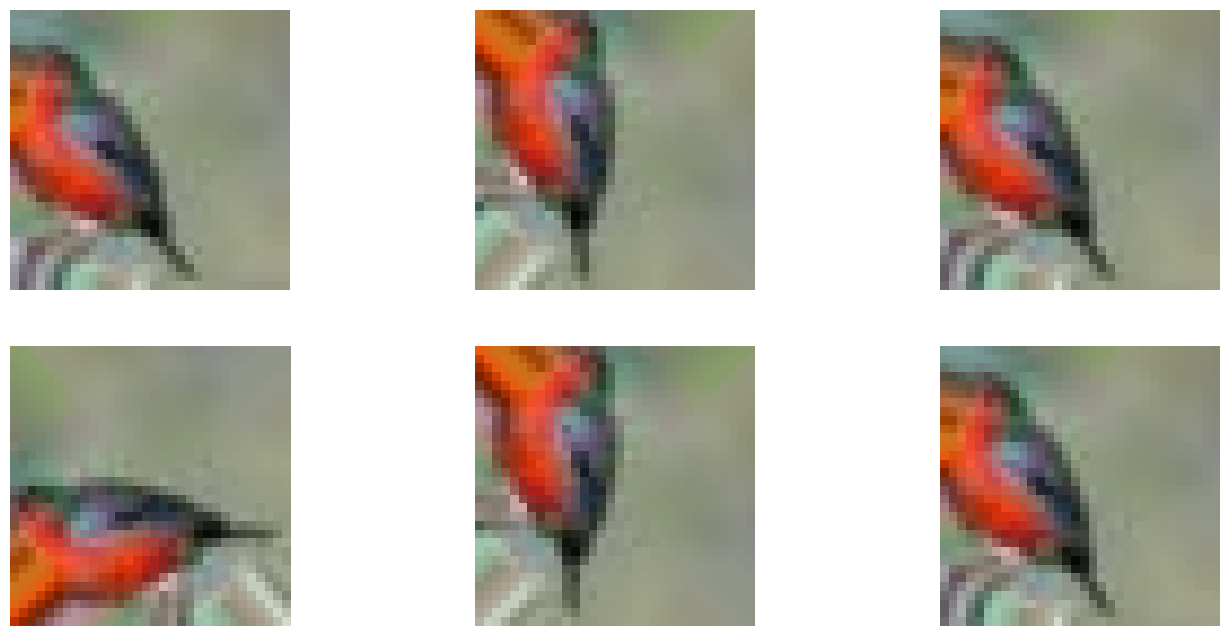

In [19]:
# CITATION: COPIED FROM https://medium.com/international-school-of-ai-data-science/increase-the-performance-of-image-classification-models-b466e1ae3101

# Assuming full_train_df.iloc[6321]['image_data'] is a 3D numpy array representing an image
test_image_data = full_train_df.iloc[6321]['image_data']

# Ensure the image data is in the correct format
# The image data should be a 3D numpy array with shape (height, width, channels)
# and the pixel values should ideally be in the range [0, 255]
if test_image_data.max() <= 1:
    test_image_data = test_image_data * 255
test_image_data = test_image_data.astype('uint8')

# Display the original image
def show_image(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# show_image(test_image_data)

# Maximum Rotation
max_rot = 60

# ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=max_rot, fill_mode='nearest')

# Reshape the image to add a batch dimension: (1, height, width, channels)
img = np.expand_dims(test_image_data, axis=0)

# Iterator
aug_iter = datagen.flow(img, batch_size=1)

# Generate samples and plot
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(17,8))
axs = ax.flatten()

# Generate batch of images
for i in range(6):
    # Convert to unsigned integers
    image = next(aug_iter)[0].astype('uint8')

    # Plot image
    axs[i].imshow(image)
    axs[i].axis('off')


## Random Shifts

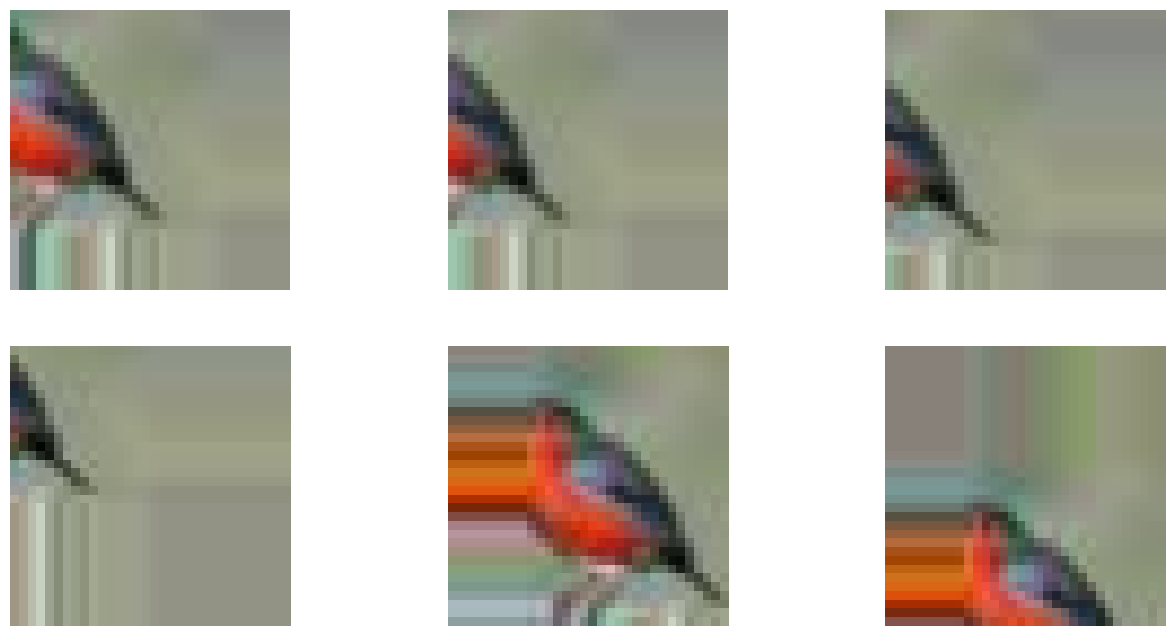

In [ ]:
# CITATION: COPIED FROM https://medium.com/international-school-of-ai-data-science/increase-the-performance-of-image-classification-models-b466e1ae3101

# Assuming full_train_df.iloc[6321]['image_data'] is a 3D numpy array representing an image
test_image_data = full_train_df.iloc[6321]['image_data']

# Ensure the image data is in the correct format
# The image data should be a 3D numpy array with shape (height, width, channels)
# and the pixel values should ideally be in the range [0, 255]
if test_image_data.max() <= 1:
    test_image_data = test_image_data * 255
test_image_data = test_image_data.astype('uint8')

# Display the original image
# def show_image(img):
#     plt.imshow(img)
#     plt.axis('off')
#     plt.show()

# show_image(test_image_data)

# ImageDataGenerator for random width and height shifts
datagen = ImageDataGenerator(width_shift_range=0.45, height_shift_range=0.45)

# Reshape the image to add a batch dimension: (1, height, width, channels)
img = np.expand_dims(test_image_data, axis=0)

# Iterator
aug_iter = datagen.flow(img, batch_size=1)

# Generate samples and plot
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16,8))
axs = ax.flatten()  # Flatten the axes array for easy indexing

# Generate batch of images
for i in range(6):
    # Convert to unsigned integers
    image = next(aug_iter)[0].astype('uint8')

    # Plot image
    axs[i].imshow(image)
    axs[i].axis('off')


## Random Flips

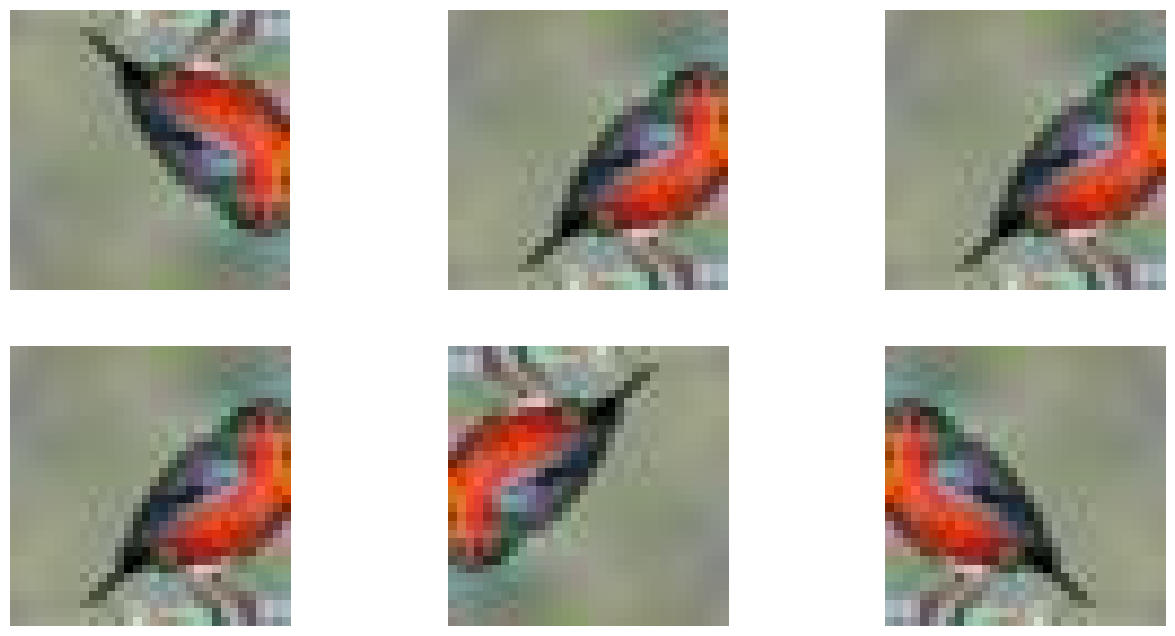

In [ ]:
# CITATION: COPIED FROM https://medium.com/international-school-of-ai-data-science/increase-the-performance-of-image-classification-models-b466e1ae3101

# import numpy as np
# import matplotlib.pyplot as plt
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming full_train_df.iloc[6321]['image_data'] is a 3D numpy array representing an image
test_image_data = full_train_df.iloc[6321]['image_data']

# Ensure the image data is in the correct format
# The image data should be a 3D numpy array with shape (height, width, channels)
# and the pixel values should ideally be in the range [0, 255]
if test_image_data.max() <= 1:
    test_image_data = test_image_data * 255
test_image_data = test_image_data.astype('uint8')

# Display the original image
# def show_image(img):
#     plt.imshow(img)
#     plt.axis('off')
#     plt.show()

# show_image(test_image_data)

# ImageDataGenerator for horizontal and vertical flips
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)

# Reshape the image to add a batch dimension: (1, height, width, channels)
img = np.expand_dims(test_image_data, axis=0)

# Iterator
aug_iter = datagen.flow(img, batch_size=1)

# Generate samples and plot
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16,8))
axs = ax.flatten()  # Flatten the axes array for easy indexing

# Generate batch of images
for i in range(6):
    # Convert to unsigned integers
    image = next(aug_iter)[0].astype('uint8')

    # Plot image
    axs[i].imshow(image)
    axs[i].axis('off')


## Random Zoom

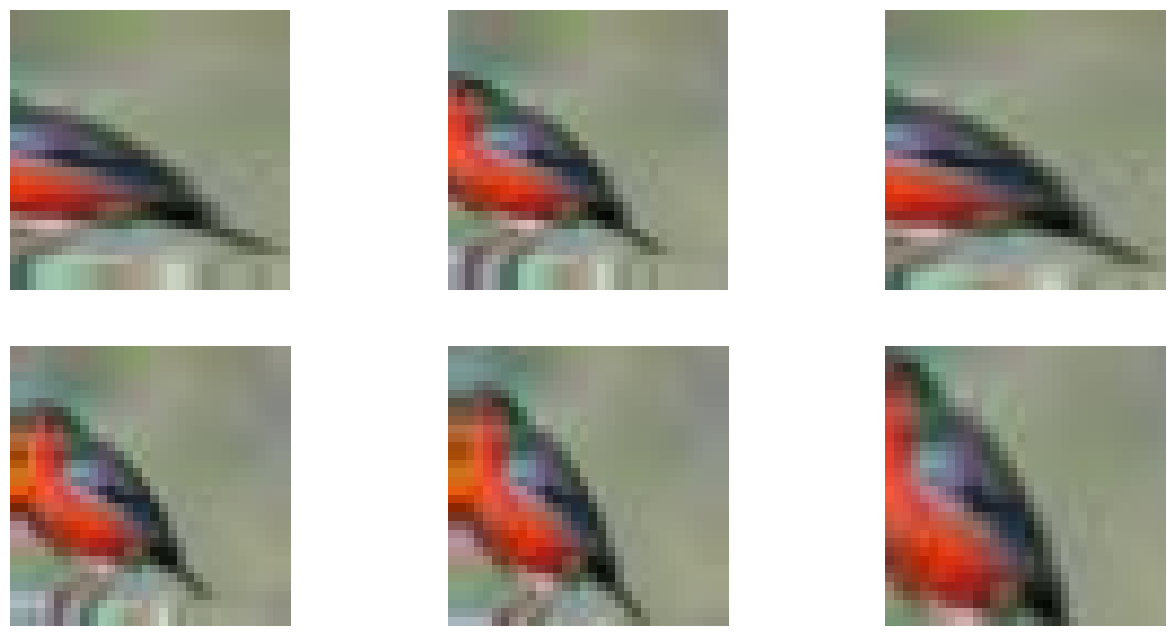

In [ ]:
# CITATION: COPIED FROM https://medium.com/international-school-of-ai-data-science/increase-the-performance-of-image-classification-models-b466e1ae3101

# import numpy as np
# import matplotlib.pyplot as plt
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming full_train_df.iloc[6321]['image_data'] is a 3D numpy array representing an image
test_image_data = full_train_df.iloc[6321]['image_data']

# Ensure the image data is in the correct format
# The image data should be a 3D numpy array with shape (height, width, channels)
# and the pixel values should ideally be in the range [0, 255]
if test_image_data.max() <= 1:
    test_image_data = test_image_data * 255
test_image_data = test_image_data.astype('uint8')

# ImageDataGenerator for zoom augmentation
datagen = ImageDataGenerator(zoom_range=[0.3,1.2])

# Reshape the image to add a batch dimension: (1, height, width, channels)
img = np.expand_dims(test_image_data, axis=0)

# Iterator
aug_iter = datagen.flow(img, batch_size=1)

# Generate samples and plot
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16,8))
axs = ax.flatten()  # Flatten the axes array for easy indexing

# Generate batch of images
for i in range(6):
    # Convert to unsigned integers
    image = next(aug_iter)[0].astype('uint8')

    # Plot image
    axs[i].imshow(image)
    axs[i].axis('off')


## 40-60 Freq Augmentation

In [ ]:
target_subclasses = subclass_counts[(subclass_counts >= 40) & (subclass_counts <= 60)].index
print(target_subclasses)

Index(['junco, snowbird', 'redshank, Tringa totanus',
       'American coot, marsh hen, mud hen, water hen, Fulica americana', 'hen',
       'ostrich, Struthio camelus', 'brambling, Fringilla montifringilla',
       'bustard', 'albatross, mollymawk',
       'red-backed sandpiper, dunlin, Erolia alpina',
       'European gallinule, Porphyrio porphyrio',
       'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
       'pelican', 'ruddy turnstone, Arenaria interpres',
       'king penguin, Aptenodytes patagonica', 'oystercatcher, oyster catcher',
       'bulbul', 'cock', 'dowitcher', 'goldfinch, Carduelis carduelis',
       'house finch, linnet, Carpodacus mexicanus',
       'robin, American robin, Turdus migratorius'],
      dtype='object')


In [ ]:
reptile_subclass_counts = reptile_train_df['subclass'].value_counts()


common iguana, iguana, Iguana iguana


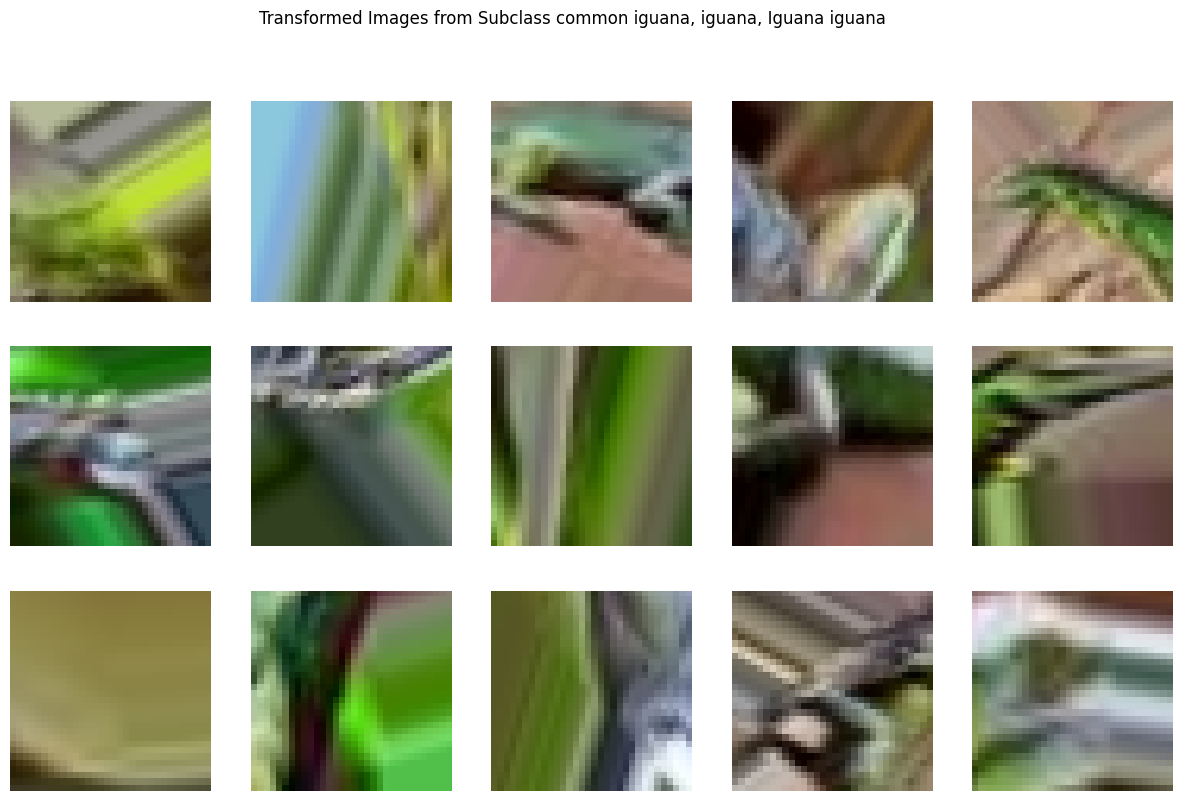

loggerhead, loggerhead turtle, Caretta caretta


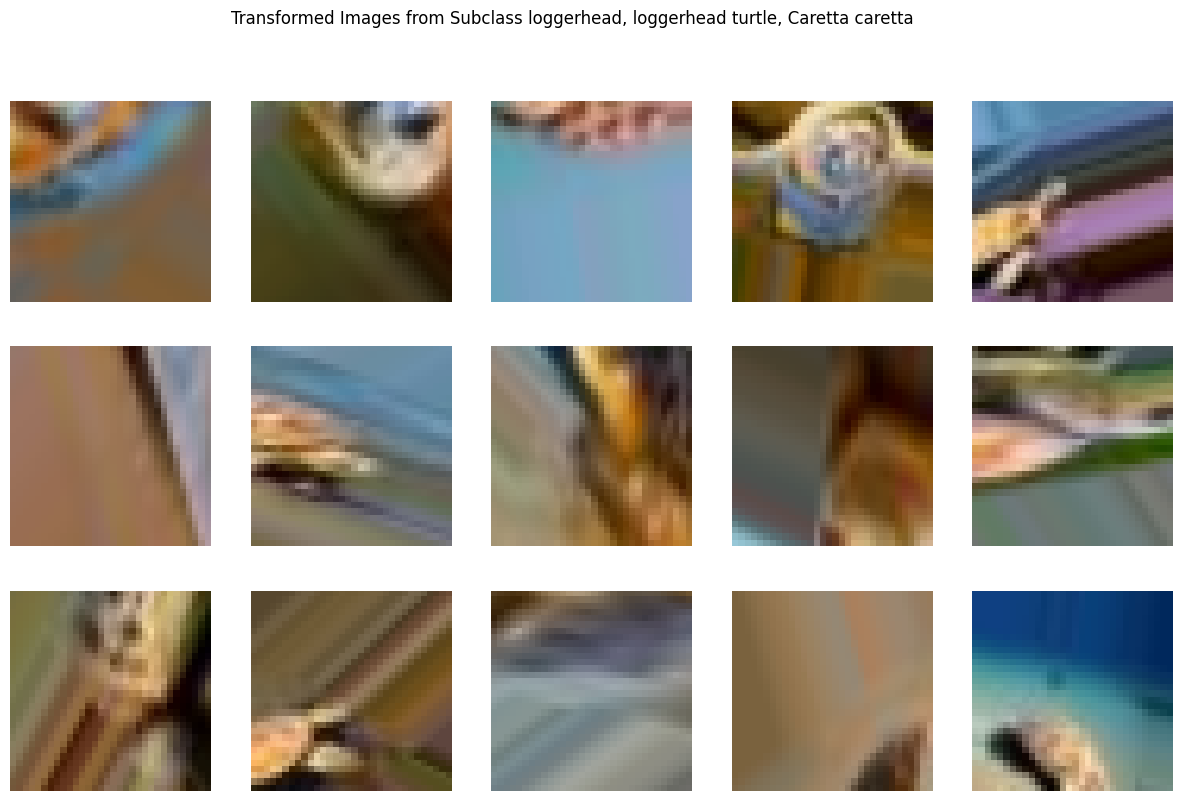

terrapin


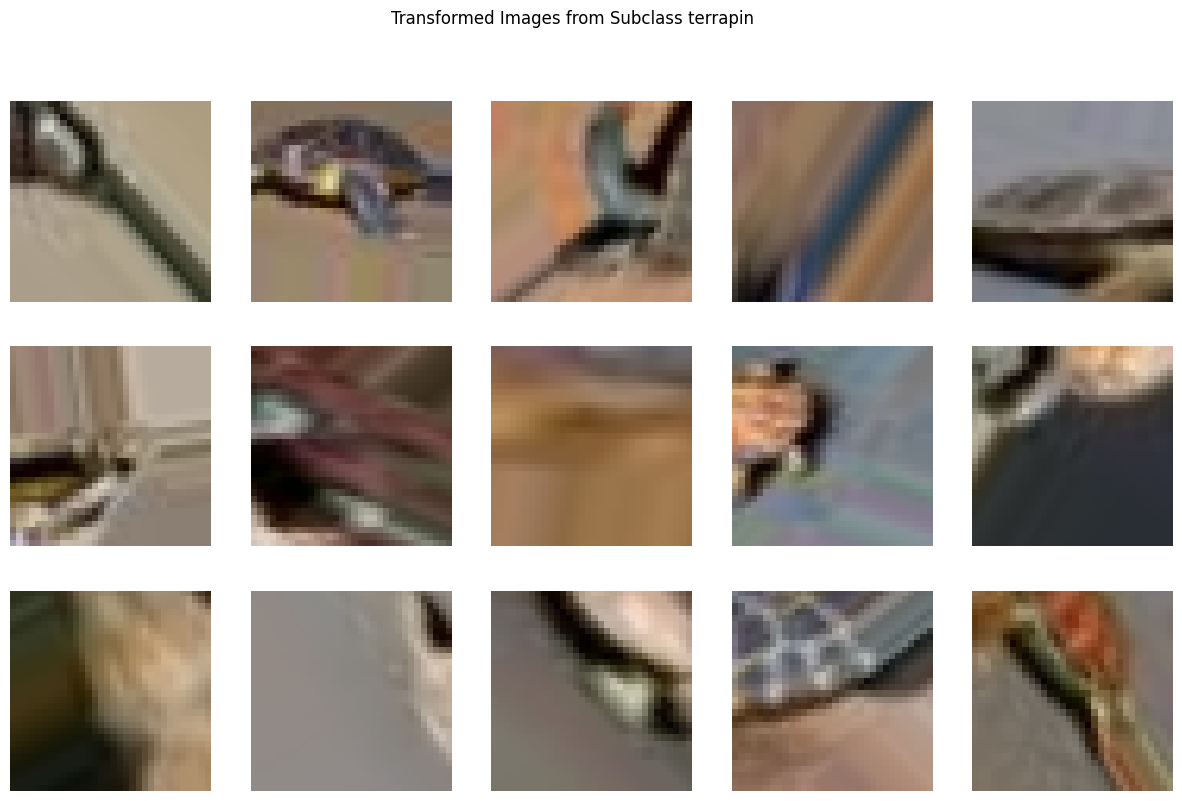

American chameleon, anole, Anolis carolinensis


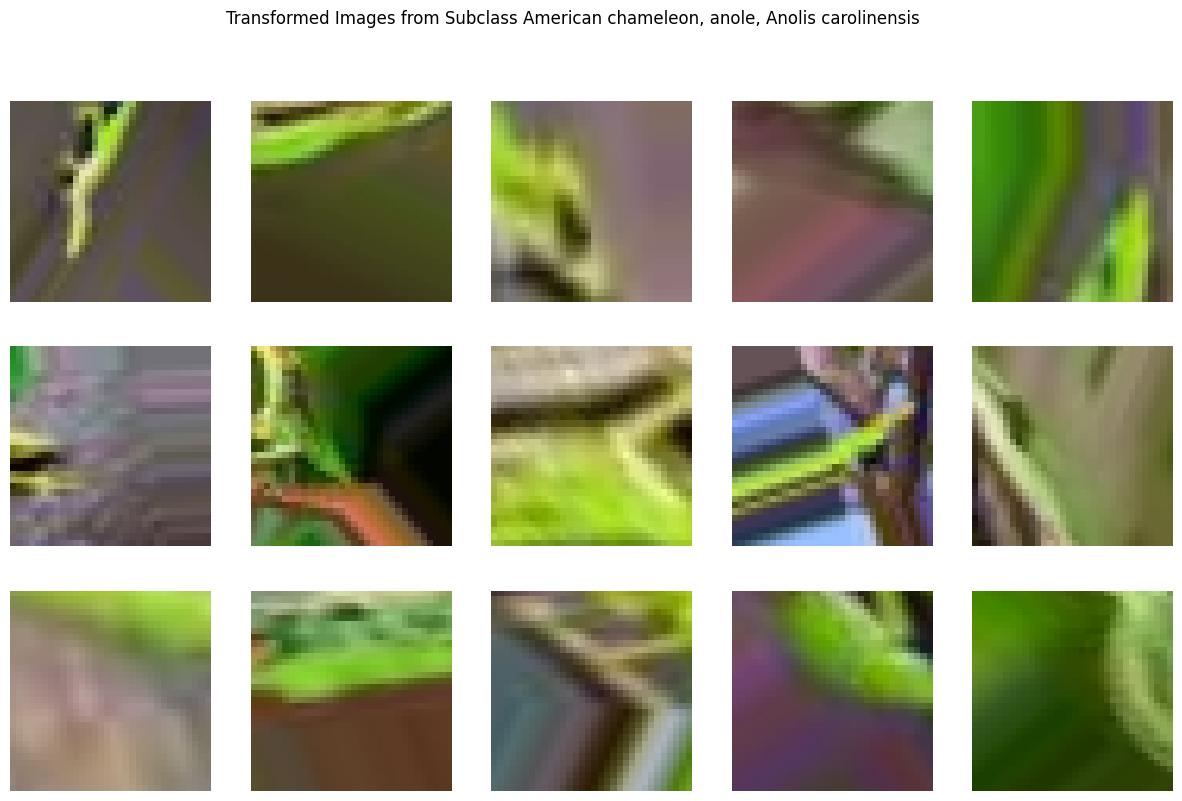

banded gecko


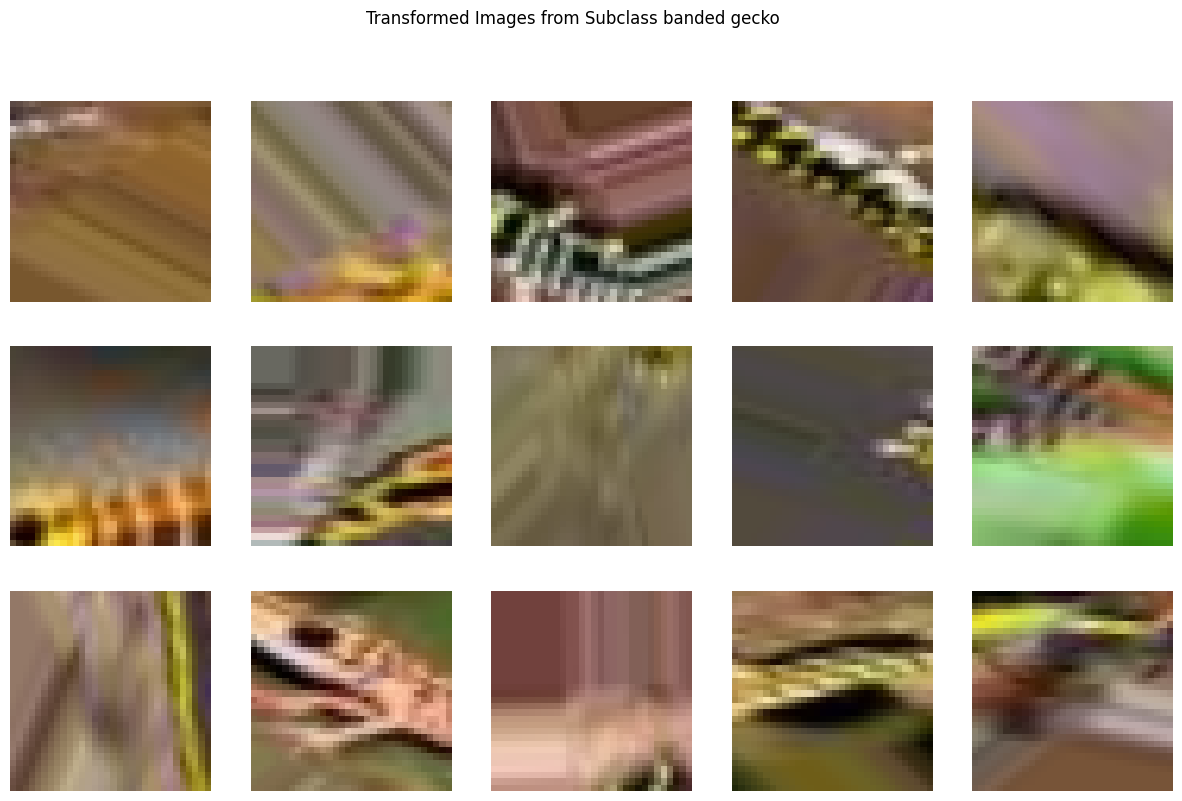

frilled lizard, Chlamydosaurus kingi


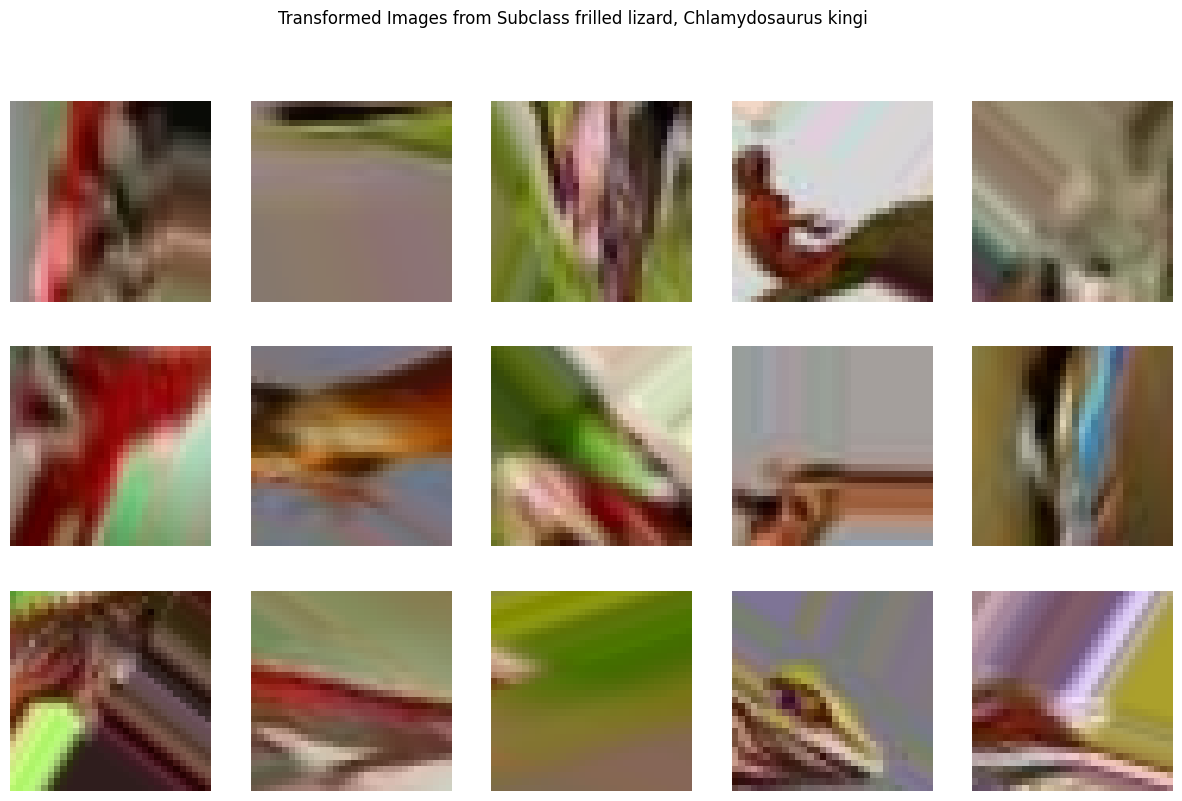

whiptail, whiptail lizard


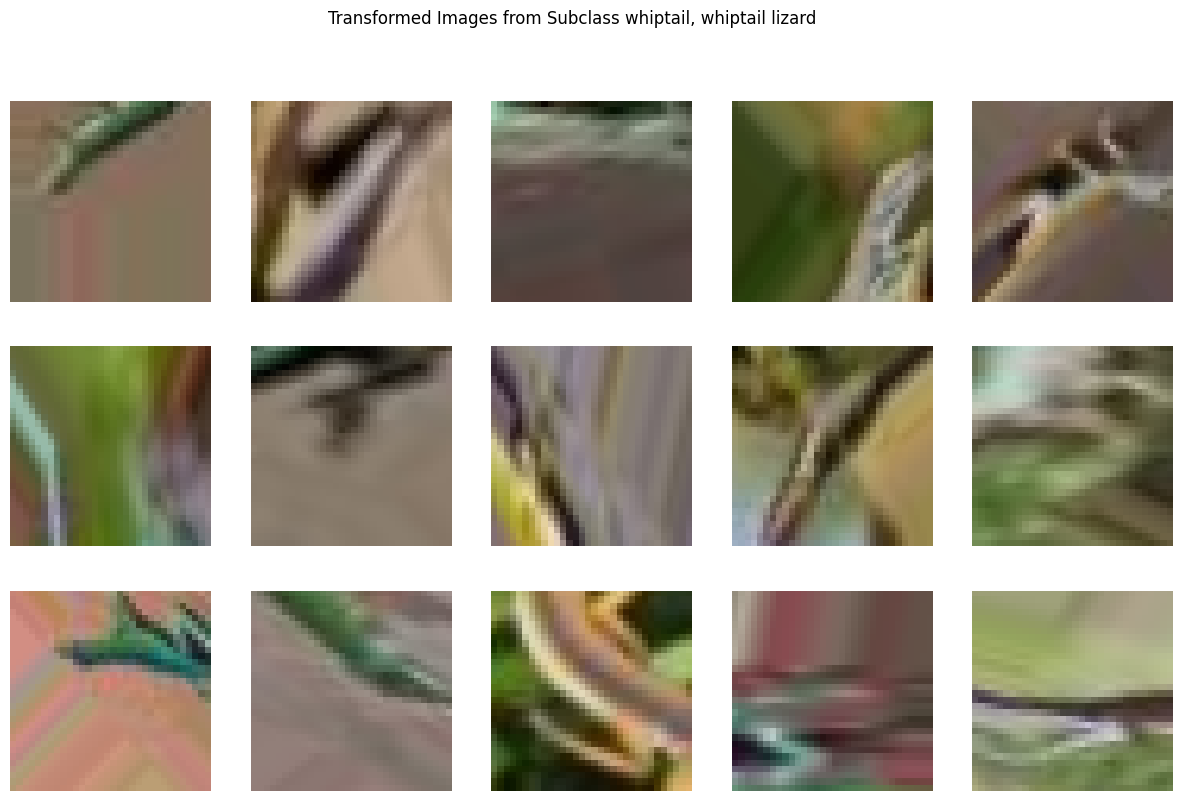

leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea


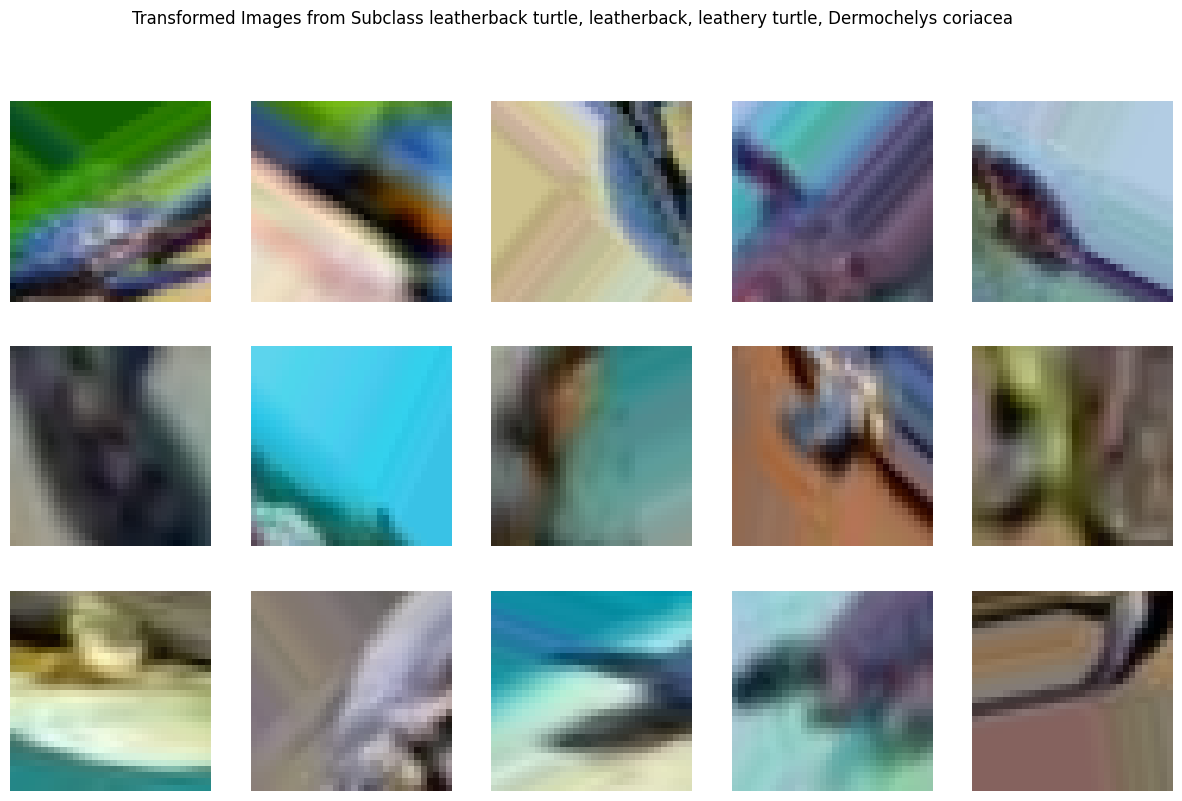

tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui


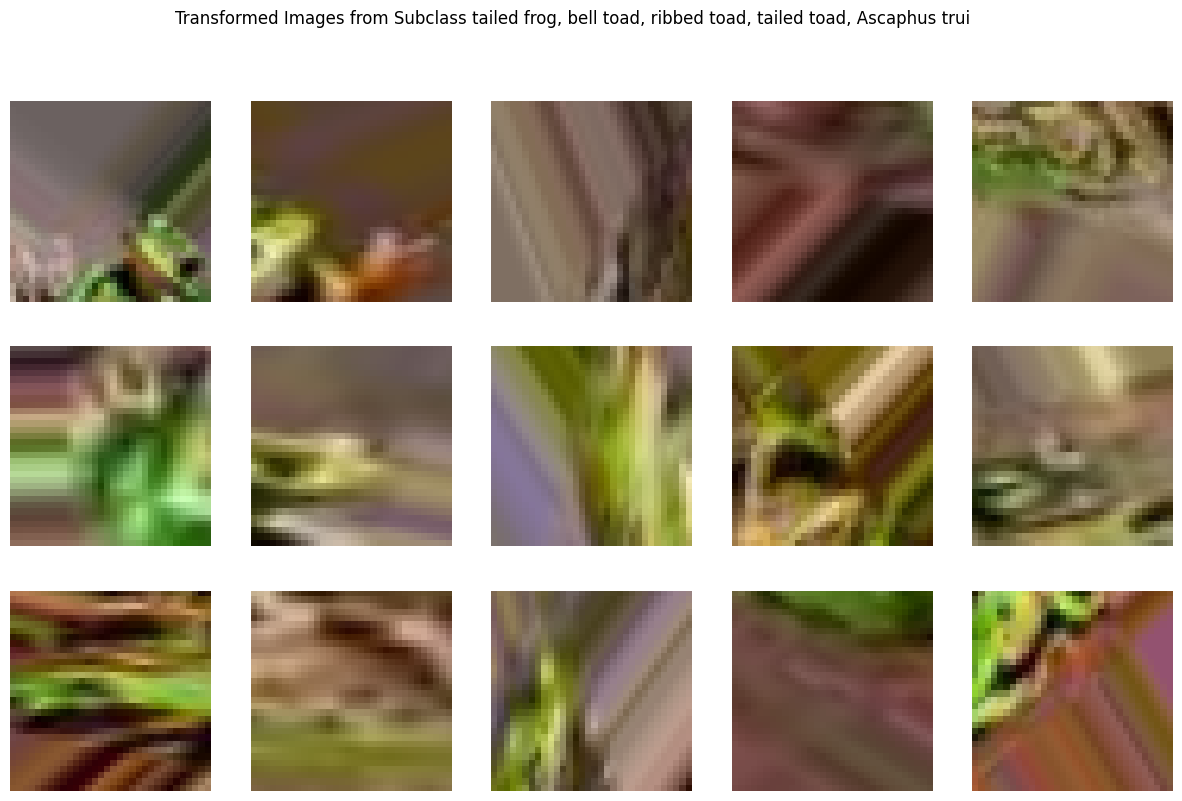

mud turtle


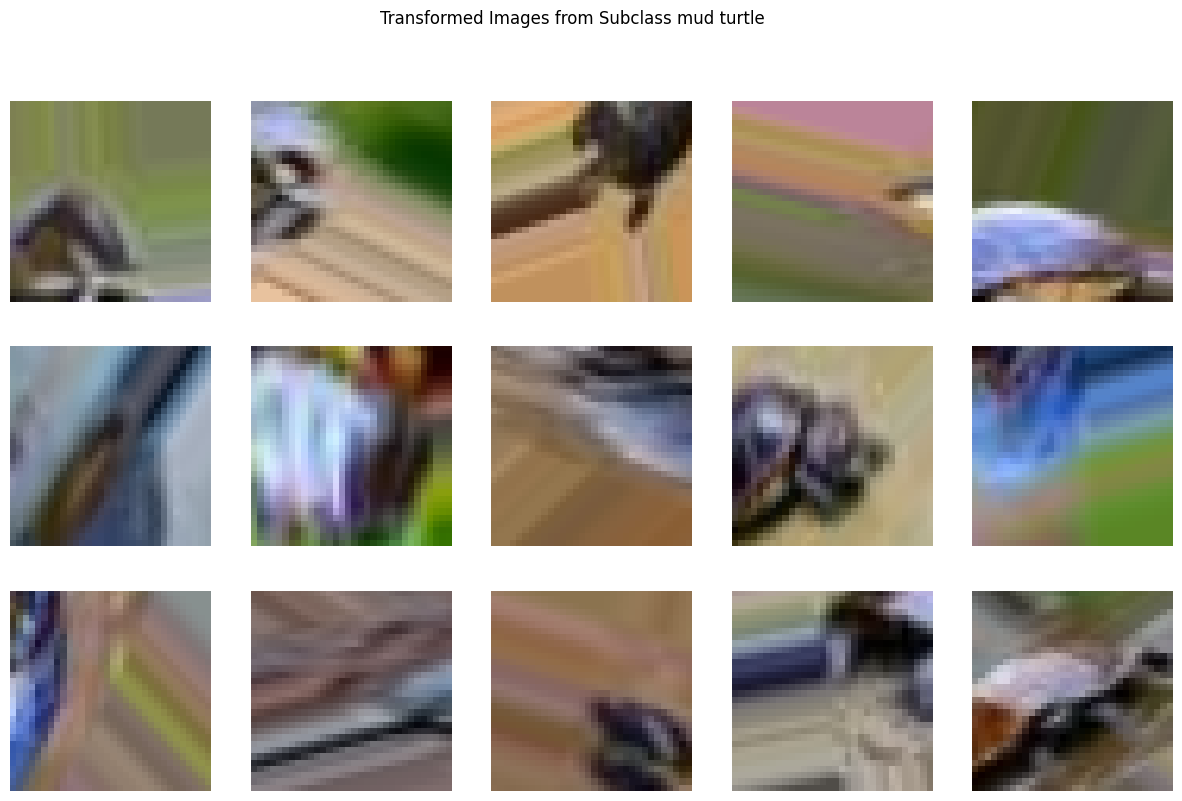

agama


KeyboardInterrupt: ignored

In [ ]:
# CITATION: Refactored from ChatGPT to visualize/test the outputs of random transformations of images.
# Dataset contains augmenting based on subclass occurrances per superclass.
# Various transformations and were performed on sharpened images.

# Step 1: Filter Subclasses
# Identify subclasses with counts under 60
target_subclasses = reptile_subclass_counts[(reptile_subclass_counts <= 60)].index

# Initialize ImageDataGenerator with different transformations
datagen_rotation = ImageDataGenerator(rotation_range=60, fill_mode='nearest')
datagen_shift = ImageDataGenerator(width_shift_range=0.45, height_shift_range=0.45, fill_mode='nearest')
datagen_flip = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
datagen_zoom = ImageDataGenerator(zoom_range=[0.3, 1.2], fill_mode='nearest')

# Iterate over each subclass
for subclass in target_subclasses:
    print(subclass)
    # Filter the DataFrame for the current subclass
    subclass_df = reptile_train_df[reptile_train_df['subclass'] == subclass]

    # If the subclass DataFrame has less than 20 entries, apply all 4 transformations
    if len(subclass_df) < 20:
        selected_images = subclass_df['image_data']

        # For each image, apply each transformation and plot
        for img_data in selected_images:
            fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # 1 row, 4 columns for the 4 transformations
            transformations = [datagen_rotation, datagen_shift, datagen_flip, datagen_zoom]

            if img_data.max() <= 1:
                img_data = img_data * 255
            img_data = img_data.astype('uint8')

            img = np.expand_dims(img_data, axis=0)

            for i, datagen in enumerate(transformations):
                aug_img = next(datagen.flow(img, batch_size=1))[0].astype('uint8')
                axs[i].imshow(aug_img)
                axs[i].axis('off')

            plt.show()

    # For subclasses with counts between 40 and 60, apply random transformations
    elif len(subclass_df) >= 40:
        selected_images = subclass_df.sample(n=15, random_state=42)['image_data']

        fig, axs = plt.subplots(3, 5, figsize=(15, 9))  # 3 rows, 5 columns
        axs = axs.flatten()
        for i, img_data in enumerate(selected_images):
            if img_data.max() <= 1:
                img_data = img_data * 255
            img_data = img_data.astype('uint8')

            img = np.expand_dims(img_data, axis=0)

            aug_img = next(datagen.flow(img, batch_size=1))[0].astype('uint8')
            axs[i].imshow(aug_img)
            axs[i].axis('off')

        plt.suptitle(f'Transformed Images from Subclass {subclass}')
        plt.show()
    else:
        print(f"Not enough samples in subclass {subclass} for sampling.")

## Produce New (Training) Dataset Images

In [ ]:
# CITATION: Refactored from ChatGPT to produce new dataset
# Dataset contains augmenting based on subclass occurrances per superclass.
# Various transformations and were performed on sharpened images.

# Initialize ImageDataGenerator with different transformations
datagen_rotation = ImageDataGenerator(rotation_range=60, fill_mode='nearest')
datagen_shift = ImageDataGenerator(width_shift_range=0.45, height_shift_range=0.45, fill_mode='nearest')
datagen_flip = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
datagen_zoom = ImageDataGenerator(zoom_range=[0.3, 1.2], fill_mode='nearest')

# Function to append new image data to the DataFrame
def append_new_image(df, img_data, original_name, suffix, superclass, subclass):
    new_name = f"{original_name.split('.')[0]}_{suffix}.jpg"
    new_row = {'image': new_name, 'image_data': img_data, 'superclass': superclass, 'subclass': subclass}
    df = df.append(new_row, ignore_index=True)
    return df

# Iterate over each subclass in the DataFrame
for index, row in full_train_df.iterrows():
    img_data = row['image_data']
    superclass = row['superclass']
    subclass = row['subclass']
    original_name = row['image']

    if img_data.max() <= 1:
        img_data = img_data * 255
    img_data = img_data.astype('uint8')
    img = np.expand_dims(img_data, axis=0)

    # Apply transformations based on the frequency of the subclass
    subclass_count = full_train_df[full_train_df['subclass'] == subclass].shape[0]

    if superclass == 'reptile' and subclass_count < 20:
        # Apply all 4 transformations
        transformations = [('1', datagen_rotation), ('2', datagen_shift),
                           ('3', datagen_flip), ('4', datagen_zoom)]
        for suffix, datagen in transformations:
            aug_img = next(datagen.flow(img, batch_size=1))[0].astype('uint8')
            full_train_df = append_new_image(full_train_df, aug_img, original_name, suffix, superclass, subclass)
    elif subclass_count >= 40 and subclass_count <= 60:
        # Apply a random transformation
        random_datagen = np.random.choice([datagen_rotation, datagen_shift, datagen_flip, datagen_zoom])
        aug_img = next(random_datagen.flow(img, batch_size=1))[0].astype('uint8')
        full_train_df = append_new_image(full_train_df, aug_img, original_name, '1', superclass, subclass)



<ipython-input-12-35e69e80210a>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-12-35e69e80210a>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-12-35e69e80210a>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-12-35e69e80210a>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-12-35e69e80210a>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Us

## Read in New Dataset and Plot New Distributions

In [ ]:
train_dir = file_path + "train_shuffle_transforms"
# test_dir = file_path + "test_shuffle"

def preprocess_image(image_path):
    image = Image.open(image_path)

    if image.size != (32, 32):
        raise ValueError("Image is not 32x32 pixels in size.")

    image_array = np.array(image).astype('float32') / 255.0

    return image_array

def create_dataframe_from_images(directory):
    filenames = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    images = [preprocess_image(os.path.join(directory, f)) for f in filenames]
    df = pd.DataFrame({'image': filenames, 'image_data': images})

    return df

train_df_sharpened = create_dataframe_from_images(train_dir)

In [ ]:
# train_df_sharpened = pd.merge(train_df_sharpened, train_data_mapping_df, on='image', how='inner')
# train_df_sharpened = pd.merge(train_df_sharpened, super_classes_mapping_df, on='superclass_index', how='inner')
# train_df_sharpened = pd.merge(train_df_sharpened, sub_classes_mapping_df, on='subclass_index', how='inner')
# train_df_sharpened = train_df_sharpened.drop(["superclass_index", "subclass_index"], axis=1)
# train_df_sharpened = train_df_sharpened.rename(columns={"sub_class_x": "superclass", "sub_class_y": "subclass"})
print(len(train_df_sharpened))
train_df_sharpened.head()

6858


image                                         image_data superclass  \
0  5472.jpg  [[[0.12156863, 0.07058824, 0.41568628], [0.435...    reptile   
1  3188.jpg  [[[0.54901963, 0.64705884, 0.6666667], [0.0784...    reptile   
2  3749.jpg  [[[0.7137255, 0.7137255, 0.6666667], [0.619607...    reptile   
3   780.jpg  [[[0.59607846, 0.6039216, 0.6], [0.6313726, 0....    reptile   
4  4422.jpg  [[[0.3529412, 0.58431375, 0.75686276], [0.0862...    reptile   

                                        subclass  
0  ringneck snake, ring-necked snake, ring snake  
1  ringneck snake, ring-necked snake, ring snake  
2  ringneck snake, ring-necked snake, ring snake  
3  ringneck snake, ring-necked snake, ring snake  
4  ringneck snake, ring-necked snake, ring snake

In [ ]:
# Create a directory for sharpened images full_train_df
transformed_img_dir = file_path + 'train_shuffle_transformed'
if not os.path.exists(transformed_img_dir):
    os.makedirs(transformed_img_dir)

# Process and save each image
for index, row in full_train_df.iterrows():
    image_data = row['image_data']  # Assuming this is a numpy array; if not, convert it

    # Convert numpy array back to image
    img = Image.fromarray((image_data * 255).astype(np.uint8))
    img.save(os.path.join(transformed_img_dir, row['image']))

print("All images have been sharpened and saved.")

All images have been sharpened and saved.


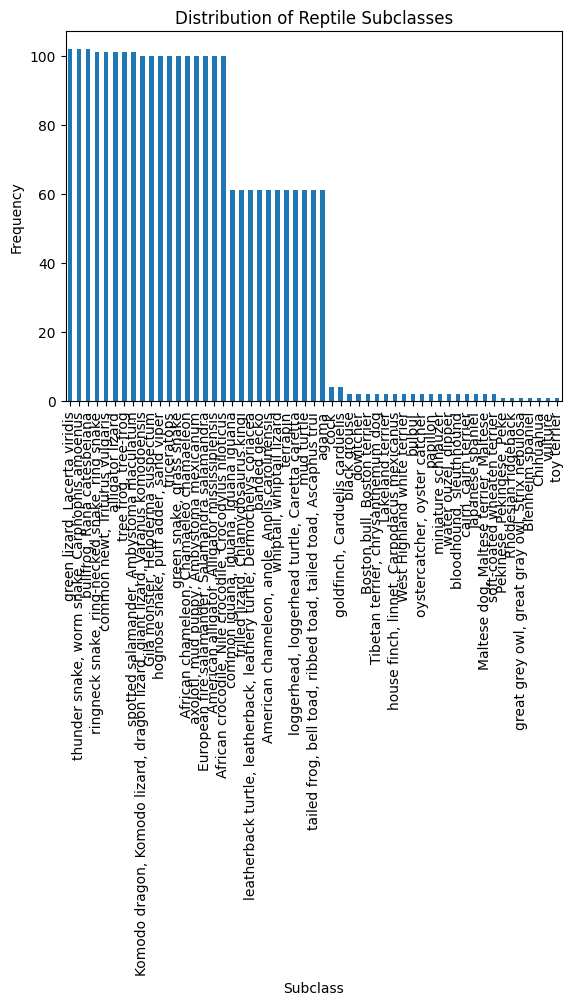

In [ ]:
reptile_train_df = train_df_sharpened[full_train_df['superclass']=='reptile']
subclass_counts = reptile_train_df['subclass'].value_counts()
subclass_counts.plot(kind='bar')
plt.title('Distribution of Reptile Subclasses')
plt.xlabel('Subclass')
plt.ylabel('Frequency')
plt.show()